In [1]:
import numpy as np
import pandas as pd

import urllib.parse
import requests
import zipfile
import pathlib

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
file_url = 'https://disk.yandex.ru/d/S8f03spLIA1wrw'

final_url = base_url + urllib.parse.urlencode(dict(public_key=file_url))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('downloaded_file.zip', 'wb') as f:
    f.write(download_response.content)

with zipfile.ZipFile('downloaded_file.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

pathlib.Path('downloaded_file.zip').unlink()

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
file_url = 'https://disk.yandex.ru/d/KN4EEkNKrF_ZXQ'

final_url = base_url + urllib.parse.urlencode(dict(public_key=file_url))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('downloaded_file.zip', 'wb') as f:
    f.write(download_response.content)

with zipfile.ZipFile('downloaded_file.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

pathlib.Path('downloaded_file.zip').unlink()

!rm -rf __MACOSX

In [4]:
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import  torch.nn.functional as F
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm import tqdm
import torchvision.transforms as transforms
import random
from collections import defaultdict
import os
from PIL import Image


In [ ]:
class MyDataset(Dataset):
    def read_classes(self, labels_file):
        classes = [0] 
        with open(labels_file, 'r') as file:
            for idx,line in enumerate(file):
                if (labels_file != 'extracted_files/celebA_train_500/celebA_anno.txt' and idx == 0):
                    continue
                if (labels_file == 'extracted_files/celebA_train_500/celebA_anno.txt'):
                    parts = line.strip().split()
                else:
                    parts = line.strip().split(',')
                    
                image_name = parts[0]  
                class_label = int(parts[1])  
                
                index = int(image_name.split('.')[0])
                while len(classes) <= index:
                    classes.append(0)
                classes[index] = class_label
        return classes
    
    def __init__(self, split, images_path, transform=None, need_crop=True, labels_file='extracted_files/celebA_train_500/celebA_anno.txt'):
        
        self.images_path = images_path
        if (labels_file is not None):
            self.labels = torch.tensor(self.read_classes(labels_file), dtype=torch.long)
        else:
            self.labels = torch.tensor([0] * 10000000)
        self.split = split
        self.transform = transform

        self.resize = transforms.Resize((224, 224))
        self.need_crop = need_crop
        
    def __len__(self):
        return len(self.split)

    def __getitem__(self, idx_):
        numb = self.split[idx_]
        label = self.labels[numb]
        image = cv2.imread(f'{self.images_path}/{numb:06d}.jpg')
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_tensor = torch.from_numpy(image).float() / 255
        image_tensor = image_tensor.permute(2, 0, 1)
        if (self.need_crop):
            image_tensor = image_tensor[:,50:190, 45:145]
        if self.transform is not None:
            image_tensor = self.transform(image_tensor)
        else:
            image_tensor = self.resize(image_tensor)
        return (image_tensor, label)

In [6]:
train_split, valid_split, test_split = [], [], []
with open('extracted_files/celebA_train_500/celebA_train_split.txt', 'r') as file:
    for line in file:
        parts = line.strip().split()
        image_name = parts[0]  
        split_label = int(parts[1])  
        
        index = int(image_name.split('.')[0])
        if (split_label == 0):
            train_split.append(index)
        if (split_label == 1):
            valid_split.append(index)
        if (split_label == 2):
            test_split.append(index)

train_split = sorted(train_split)
valid_split = sorted(valid_split)
test_split = sorted(test_split)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])


train_dataset = MyDataset(train_split, images_path='extracted_files/celebA_train_500/celebA_imgs', transform=train_transform, labels_file='extracted_files/celebA_train_500/celebA_anno.txt')
valid_dataset = MyDataset(valid_split, images_path='extracted_files/celebA_train_500/celebA_imgs', transform=valid_transform, labels_file='extracted_files/celebA_train_500/celebA_anno.txt')

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

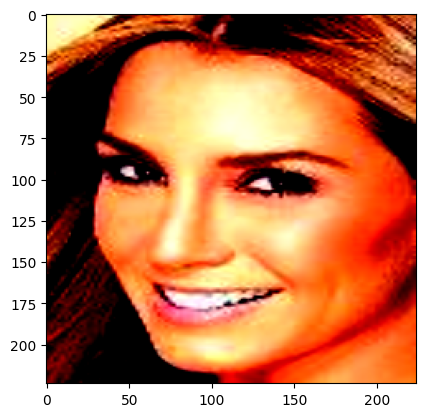

In [9]:
mean=torch.tensor([0.485, 0.456, 0.406])
std =torch.tensor([0.229, 0.224, 0.225])
plt.imshow(train_dataset[0][0].permute(1, 2, 0) * mean + std)

In [ ]:
import torchvision.models as models

class ArcFaceLoss(nn.Module):
    def __init__(self, m, s):
        super().__init__()
        self.m_cos = torch.cos(torch.tensor(m))
        self.m_sin = torch.sin(torch.tensor(m))

        self.s = s
    def forward(self, cosine, target):
        # logits are cosines
        logits = cosine.clone()
        batch_idxs = torch.arange(0, logits.shape[0], 1)

        v = logits[batch_idxs, target]
        sin_v = torch.sqrt(torch.clamp(1.0 - v*v, min=0.0))

        logits[batch_idxs, target] = v * self.m_cos - sin_v * self.m_sin

        assert torch.isnan(torch.max(logits)) == False
        logits = logits * self.s
        
        
        return F.cross_entropy(logits, target.squeeze(-1))


class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2) 
        self.conv_seq = nn.Sequential(*list(resnet101.children())[:-1], 
                                      nn.Flatten(),
                                      nn.Linear(2048, 512)
                                     )

        
        
        self.weight = nn.Parameter(torch.Tensor(500, 512))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, X, need_embeding=False):
        out = self.conv_seq(X)
        
        if torch.isnan(out).any():
           print("NaN found in out")

        
        weigth_norm = F.normalize(self.weight, p=2, dim=1)
        out_norm = F.normalize(out, p=2, dim=1)
        if (need_embeding == True):
            return out_norm
        return F.linear(out_norm, weigth_norm, bias=None)

tmp_model = MyModel()
del tmp_model

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 179MB/s]


In [11]:
def plot_metrics(metrics):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Training Loss', color='blue')
    plt.plot(metrics['valid_losses'], label='Validation Loss', color='orange')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['valid_acc'], label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
def compute_embeddings(model, dataloader, device):
    model.eval()

    emb = []
    for batch_x, batch_y in dataloader:
        with torch.no_grad():
            batch_x = batch_x.to(device)

            logits = model(batch_x, need_embeding = True)
            for cur in logits:
                emb.append(cur)

    emb = torch.stack(emb, dim=0).requires_grad_(False)
    return emb


def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings, dataset=None):
    similarities = []
    
    for class_name, img_names in query_dict.items():
        indices = [query_img_names.index(img_name) for img_name in img_names if img_name in query_img_names]
        if len(indices) < 2:
            continue
        # print(type(query_embeddings), indices)
        if (dataset):
            for cur in indices:
                assert int(dataset[cur][1].item()) == int(class_name)
        class_embeddings = query_embeddings[indices]
        
        cos_sim_matrix = F.cosine_similarity(
            class_embeddings.unsqueeze(1),
            class_embeddings.unsqueeze(0),
            dim=-1
        ) 
        
        triu_indices = torch.triu_indices(cos_sim_matrix.size(0), cos_sim_matrix.size(1), offset=1)
        
        positive_pairs = cos_sim_matrix[triu_indices[0], triu_indices[1]]

        similarities.extend(positive_pairs.tolist())
    
    return similarities



def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings, dataset=None):
    class_to_indices = {}
    for class_name, img_names in query_dict.items():
        indices = [query_img_names.index(img_name) for img_name in img_names if img_name in query_img_names]

        if (dataset):
            for cur in indices:
                assert int(dataset[cur][1].item()) == int(class_name)
        
        if indices:
            class_to_indices[class_name] = indices
        
    negative_similarities = []
    all_classes = list(class_to_indices.keys())
    
    for i, class_i in enumerate(all_classes):
        
        for j in range(i + 1, len(all_classes)):
            class_j = all_classes[j]
            
            indices_i = class_to_indices[class_i]
            indices_j = class_to_indices[class_j]
            
            embeddings_i = query_embeddings[indices_i]
            embeddings_j = query_embeddings[indices_j]
            
            cos_sim = F.cosine_similarity(
                embeddings_i.unsqueeze(1),
                embeddings_j.unsqueeze(0),
                dim=-1
            ) 
            
            negative_similarities.extend(cos_sim.flatten().tolist())

    return negative_similarities


def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  similarities = []
  query_array = query_embeddings.cpu().detach().numpy()
  distractors_array = distractors_embeddings.cpu().detach().numpy()

  query_norm = query_array / np.linalg.norm(query_array, axis=1, keepdims=True)
  distractors_norm = distractors_array / np.linalg.norm(distractors_array, axis=1, keepdims=True)

  cosine_similarities = np.dot(query_norm, distractors_norm.T)
  cosine_similarities = cosine_similarities.reshape(-1)
  return cosine_similarities.tolist()

def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    false = np.concatenate((cosine_query_neg, cosine_query_distractors), dtype=float)

    false = np.sort(false)[::-1]
    
    idx_threshold = int(len(false) * fpr)
    
    threshold = false[idx_threshold]
    cnt = sum([1 for sim in cosine_query_pos  if sim >= threshold])
    
    return threshold, cnt / len(cosine_query_pos)

def compute_ir_metric(model, fpr=[0.1]):
    f = open('./celebA_ir/celebA_anno_query.csv', 'r')
    query_lines = f.readlines()[1:]
    f.close()
    query_lines = [x.strip().split(',') for x in query_lines]
    
    query_img_names = [x[0] for x in query_lines]
    
    query_dict = defaultdict(list)
    for img_name, img_class in query_lines:
      query_dict[img_class].append(img_name)
    
    distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')
    
    query_split = []
    
    for filename in query_img_names:
        if filename.endswith('.jpg'):
            number = filename.split('.')[0]
            query_split.append(int(number))
    
    distractors_split = []
    
    for filename in distractors_img_names:
        if filename.endswith('.jpg'):
            number = filename.split('.')[0]
            distractors_split.append(int(number))
    
    query_dataset = MyDataset(query_split, images_path='celebA_ir/celebA_query', transform=valid_transform, need_crop=False, labels_file='celebA_ir/celebA_anno_query.csv')
    distractors_dataset = MyDataset(distractors_split, images_path='celebA_ir/celebA_distractors', transform=valid_transform, need_crop=False, labels_file=None)
    
    query_dataloader = DataLoader(query_dataset, batch_size=64, shuffle=False)
    distractors_dataloader = DataLoader(distractors_dataset, batch_size=64, shuffle=False)
    
    query_embeddings = compute_embeddings(model, query_dataloader, device)
    distractors_embeddings = compute_embeddings(model, distractors_dataloader, device)
    
    cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                                query_embeddings, query_dataset)
    
    cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                                query_embeddings, query_dataset)
    
    cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                                distractors_embeddings)

    ans = []
    for cur_fpr in fpr:
        ans.append(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,fpr=cur_fpr))
    return ans

In [13]:
def pretty_print_ir_metric(ir_metrics):
    print("IR metric:")
    print("╔══════════════╦══════════════╗")
    print("║ Threshold    ║     (TPR)    ║")
    print("╠══════════════╬══════════════╣")
    
    for threshold, tpr in ir_metrics:
        print(f"║      {threshold:.03f}   ║     {tpr:.03f}    ║")
    
    print("╚══════════════╩══════════════╝")

def train(model, criterion, optimizer, train_dataloader, valid_dataloader, epochs, device, metrics, scheduler):
    
    best_model = copy.deepcopy(model)
    best_ir = 0
    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}:\n')
        model.train()
        train_loss = 0
        valid_loss = 0

        train_cnt_right = 0
        train_size = 0
        for idx, (batch_x, batch_y) in enumerate(tqdm(train_dataloader)):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device).long()

            logits = model(batch_x)
            cur_loss = criterion(logits, batch_y)
            cur_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += cur_loss.item()

            preds = torch.argmax(logits, dim=1)
            
            train_cnt_right += torch.sum(preds == batch_y)
            train_size += batch_y.shape[0]

        valid_cnt_right = 0
        valid_size = 0
        model.eval()
        for batch_x, batch_y in valid_dataloader:
            with torch.no_grad():
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device).long()
    
                logits = model(batch_x)
                cur_loss = criterion(logits, batch_y)
                valid_loss += cur_loss.item()
                preds = torch.argmax(logits, dim=1)
                
                valid_cnt_right += torch.sum(preds == batch_y)
                valid_size += batch_y.shape[0]

        train_loss /= len(train_dataloader)
        valid_loss /= len(valid_dataloader)
        print(f'Train Loss: {train_loss:.5f}\nTrain accuracy: {(train_cnt_right/train_size * 100):.2f}%\nValid Loss: {valid_loss:.5f}\nValid accuracy: {(valid_cnt_right/valid_size * 100):.2f}%')
        metrics['train_losses'].append(train_loss)
        metrics['valid_losses'].append(valid_loss)
        metrics['valid_acc'].append(valid_cnt_right/valid_size)
        
        if scheduler is not None:
            scheduler.step(valid_loss)
            
        cur_ir_metric = compute_ir_metric(model, [0.05, 0.1, 0.2])
        print(f'IR metric TPR@FPR: 0.05, 0.1, 0.2\n')
        pretty_print_ir_metric(cur_ir_metric)
        if (cur_ir_metric[1][1] > best_ir):
            best_model = copy.deepcopy(model)
            best_ir = valid_cnt_right/valid_size
    return best_model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

criterion = ArcFaceLoss(m=0.5, s=64) # 40?
model = MyModel().to(device)
model = nn.DataParallel(model, device_ids=['cuda:0', 'cuda:1']) 

metrics = {
    'train_losses': [],
    'valid_losses': [],
    'valid_acc': []
}

print('ok')

Using device: cuda
ok


In [15]:
optimizer = torch.optim.Adam(model.module.parameters(), lr= 1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [16]:
best_model = train(model, criterion, optimizer, train_dataloader, valid_dataloader, 10, device, metrics, scheduler)

Epoch 1:



100%|██████████| 134/134 [01:43<00:00,  1.30it/s]


Train Loss: 37.47117
Train accuracy: 0.78%
Valid Loss: 36.46901
Valid accuracy: 1.38%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.949   ║     0.127    ║
║      0.944   ║     0.215    ║
║      0.938   ║     0.359    ║
╚══════════════╩══════════════╝
Epoch 2:



100%|██████████| 134/134 [01:42<00:00,  1.31it/s]


Train Loss: 35.74541
Train accuracy: 9.48%
Valid Loss: 35.15791
Valid accuracy: 16.35%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.890   ║     0.251    ║
║      0.878   ║     0.376    ║
║      0.863   ║     0.542    ║
╚══════════════╩══════════════╝
Epoch 3:



100%|██████████| 134/134 [01:42<00:00,  1.30it/s]


Train Loss: 33.63838
Train accuracy: 34.38%
Valid Loss: 33.26485
Valid accuracy: 37.75%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.696   ║     0.295    ║
║      0.661   ║     0.434    ║
║      0.617   ║     0.615    ║
╚══════════════╩══════════════╝
Epoch 4:



100%|██████████| 134/134 [01:43<00:00,  1.30it/s]


Train Loss: 29.65032
Train accuracy: 64.28%
Valid Loss: 30.93670
Valid accuracy: 50.59%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.454   ║     0.382    ║
║      0.407   ║     0.517    ║
║      0.348   ║     0.670    ║
╚══════════════╩══════════════╝
Epoch 5:



100%|██████████| 134/134 [01:42<00:00,  1.30it/s]


Train Loss: 24.09026
Train accuracy: 84.74%
Valid Loss: 27.91333
Valid accuracy: 61.18%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.395   ║     0.412    ║
║      0.351   ║     0.534    ║
║      0.299   ║     0.679    ║
╚══════════════╩══════════════╝
Epoch 6:



100%|██████████| 134/134 [01:43<00:00,  1.30it/s]


Train Loss: 18.30483
Train accuracy: 93.35%
Valid Loss: 25.19929
Valid accuracy: 66.56%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.341   ║     0.427    ║
║      0.297   ║     0.551    ║
║      0.247   ║     0.694    ║
╚══════════════╩══════════════╝
Epoch 7:



100%|██████████| 134/134 [01:42<00:00,  1.30it/s]


Train Loss: 12.94021
Train accuracy: 97.25%
Valid Loss: 22.89697
Valid accuracy: 72.20%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.335   ║     0.404    ║
║      0.286   ║     0.537    ║
║      0.229   ║     0.689    ║
╚══════════════╩══════════════╝
Epoch 8:



100%|██████████| 134/134 [01:42<00:00,  1.30it/s]


Train Loss: 8.73009
Train accuracy: 98.78%
Valid Loss: 21.14541
Valid accuracy: 74.28%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.294   ║     0.443    ║
║      0.250   ║     0.569    ║
║      0.200   ║     0.705    ║
╚══════════════╩══════════════╝
Epoch 9:



100%|██████████| 134/134 [01:42<00:00,  1.30it/s]


Train Loss: 5.57051
Train accuracy: 99.50%
Valid Loss: 19.64115
Valid accuracy: 76.41%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.265   ║     0.471    ║
║      0.222   ║     0.592    ║
║      0.175   ║     0.724    ║
╚══════════════╩══════════════╝
Epoch 10:



100%|██████████| 134/134 [01:42<00:00,  1.30it/s]


Train Loss: 3.33319
Train accuracy: 99.80%
Valid Loss: 18.81329
Valid accuracy: 77.48%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.239   ║     0.461    ║
║      0.199   ║     0.576    ║
║      0.154   ║     0.709    ║
╚══════════════╩══════════════╝


In [17]:
optimizer = torch.optim.Adam(model.module.parameters(), lr= 4e-5)

In [18]:
best_model = train(model, criterion, optimizer, train_dataloader, valid_dataloader, 5, device, metrics, scheduler)

Epoch 1:



100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Train Loss: 1.64988
Train accuracy: 99.98%
Valid Loss: 17.58403
Valid accuracy: 78.91%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.250   ║     0.463    ║
║      0.208   ║     0.581    ║
║      0.161   ║     0.713    ║
╚══════════════╩══════════════╝
Epoch 2:



100%|██████████| 134/134 [01:46<00:00,  1.26it/s]


Train Loss: 0.99951
Train accuracy: 99.98%
Valid Loss: 17.63052
Valid accuracy: 79.45%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.236   ║     0.465    ║
║      0.193   ║     0.588    ║
║      0.146   ║     0.725    ║
╚══════════════╩══════════════╝
Epoch 3:



100%|██████████| 134/134 [01:45<00:00,  1.27it/s]


Train Loss: 0.65825
Train accuracy: 99.98%
Valid Loss: 17.51086
Valid accuracy: 79.18%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.247   ║     0.463    ║
║      0.206   ║     0.584    ║
║      0.159   ║     0.714    ║
╚══════════════╩══════════════╝
Epoch 4:



100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Train Loss: 0.47681
Train accuracy: 99.99%
Valid Loss: 17.40686
Valid accuracy: 79.66%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.238   ║     0.456    ║
║      0.197   ║     0.577    ║
║      0.151   ║     0.717    ║
╚══════════════╩══════════════╝
Epoch 5:



100%|██████████| 134/134 [01:44<00:00,  1.29it/s]


Train Loss: 0.35475
Train accuracy: 99.99%
Valid Loss: 17.14850
Valid accuracy: 79.71%
IR metric TPR@FPR: 0.05, 0.1, 0.2

IR metric:
╔══════════════╦══════════════╗
║ Threshold    ║     (TPR)    ║
╠══════════════╬══════════════╣
║      0.240   ║     0.465    ║
║      0.198   ║     0.588    ║
║      0.152   ║     0.717    ║
╚══════════════╩══════════════╝


In [19]:
!ls

celebA_ir  extracted_files  __notebook__.ipynb


In [20]:
model = copy.deepcopy(best_model)

In [21]:
metrics['valid_acc'] = [float(cur) for cur in metrics['valid_acc']]

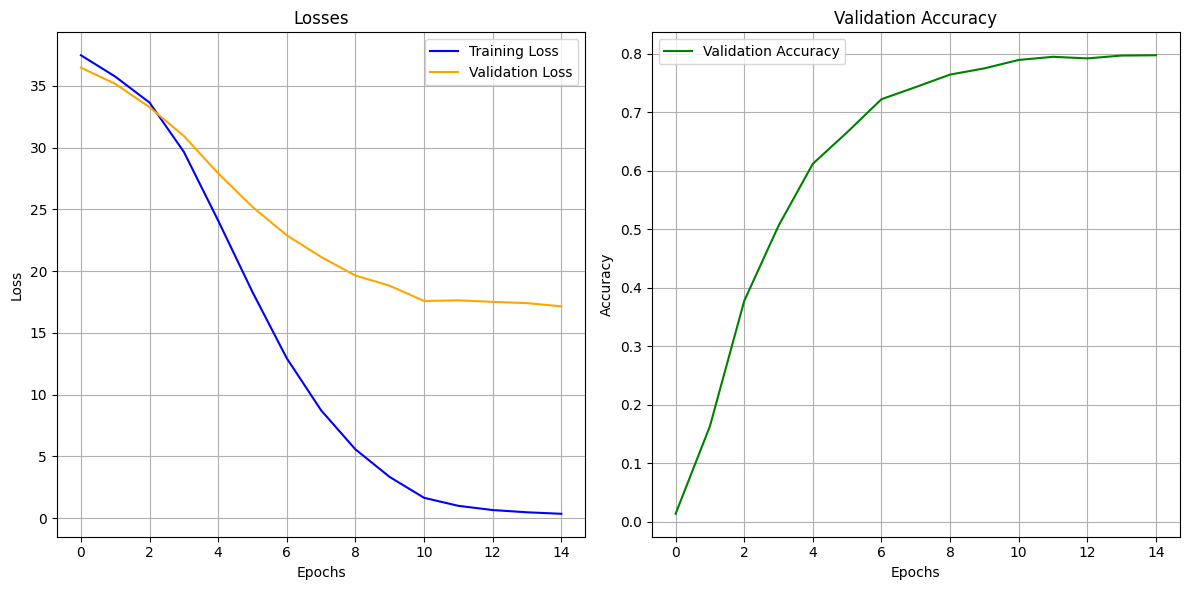

In [22]:
plot_metrics(metrics)

In [23]:
torch.save(model.module.state_dict(), '/kaggle/working/best_model')

In [24]:
model = MyModel().to(device)
model.load_state_dict(torch.load('best_model'))

print('ok')

ok


In [25]:
def evaluate_model(model, test_dataloader):
    test_cnt_right = 0
    test_size = 0
    model.eval()
    for batch_x, batch_y in tqdm(test_dataloader):
        with torch.no_grad():
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device).long()

            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1)
            
            test_cnt_right += torch.sum(preds == batch_y)
            test_size += batch_y.shape[0]

    print(f'Test accuracy: {(test_cnt_right/test_size*100):.02f}%')


test_dataset = MyDataset(test_split, images_path='extracted_files/celebA_train_500/celebA_imgs', transform=valid_transform, labels_file='extracted_files/celebA_train_500/celebA_anno.txt')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
evaluate_model(model, test_dataloader)

100%|██████████| 25/25 [00:10<00:00,  2.44it/s]

Test accuracy: 79.23%


100%|██████████| 8544/8544 [00:21<00:00, 398.55it/s]


{234: 21, 122: 21, 384: 11, 344: 21, 411: 14, 426: 21, 435: 21, 190: 14, 125: 6, 64: 20}


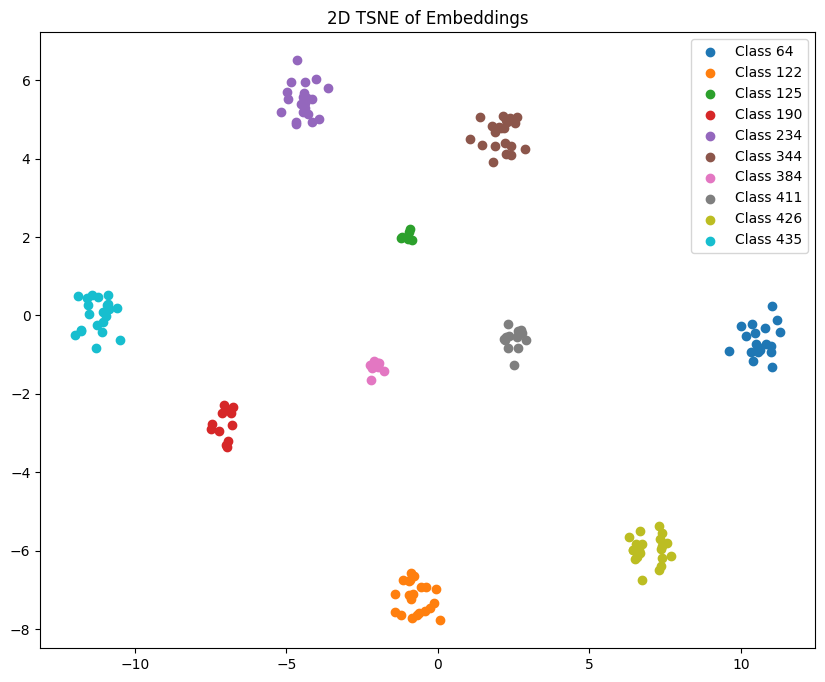

In [26]:
from sklearn.manifold import TSNE

def plot_emb(model, dataset):
    model.eval
    classes = np.random.choice(np.arange(0, 499), size=10)

    emb = {}
    for cur in classes:
        emb[int(cur)] = 0

    all_embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in tqdm(dataset):
            if (int(y) in classes):
                x = x.to(device).unsqueeze(0)
                #print(model(x, need_embeding=True))
                all_embeddings.append(model(x, need_embeding = True).detach().cpu())
                labels.append(int(y))
                
                emb[int(y)] += 1
    print(emb)
    

    all_embeddings = np.vstack(all_embeddings)

    pca = TSNE(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings)

    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        idx = np.array(labels) == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f'Class {label}')

    plt.title('2D TSNE of Embeddings')
    plt.legend()
    plt.show()

plot_emb(model, train_dataset)

In [27]:
!ls

best_model  celebA_ir  extracted_files	__notebook__.ipynb


In [28]:
thr, tpr = [], []
fprs = []
for fpr in tqdm(np.arange(0.05, 0.9, 0.05)):
    fprs.append(fpr)
cur_ir_metric = compute_ir_metric(model,fpr=fprs)
for cur in cur_ir_metric:
    thr.append(cur[0])
    tpr.append(cur[1])

100%|██████████| 17/17 [00:00<00:00, 141474.54it/s]


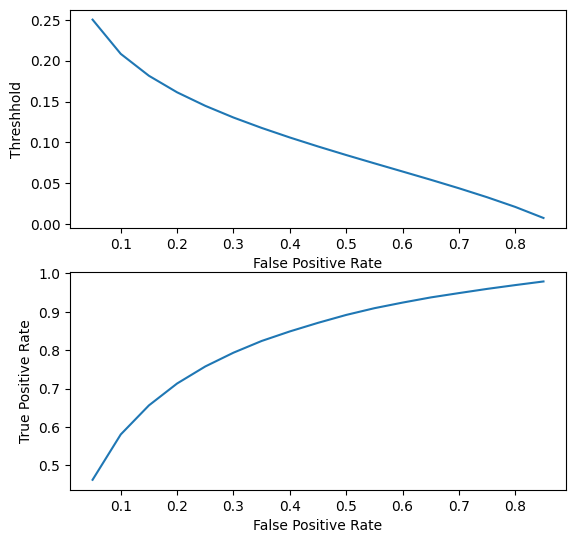

In [29]:
plt.subplot(2, 1, 1)
plt.plot(np.arange(0.05, 0.9, 0.05), thr)
plt.ylabel('Threshhold')
plt.xlabel('False Positive Rate')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0.05, 0.9, 0.05), tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplots_adjust(bottom=0, top=1)

In [30]:
rm -rf celebA_ir

In [31]:
rm -rf extracted_files

In [32]:
!ls

best_model  __notebook__.ipynb
